In [27]:
# Importazione delle librerie essenziali
import pandas as pd  # Gestione dei dati con DataFrame
import numpy as np

# Librerie per la visualizzazione dei dati
import plotly.graph_objects as go  # Visualizzazioni interattive avanzate
import plotly.subplots as sp  # Creazione di subplots interattivi
import seaborn as sns  # Grafici statistici
import matplotlib.pyplot as plt  # Grafici statici

# Librerie aggiuntive per l'analisi e la formattazione dei dati
import numpy as np  # Operazioni numeriche
import scipy.interpolate as spi  # Interpolazione e smoothing delle curve
import matplotlib.ticker as mtick  # Formattazione degli assi


# Importazione delle librerie necessarie
import plotly.graph_objects as go
from plotly.subplots import make_subplots

# Configurazione per visualizzare tutte le colonne nei DataFrame
pd.set_option('display.max_columns', None)

# Impostare la visualizzazione dei numeri in formato normale
pd.set_option('display.float_format', '{:.0f}'.format)

In [3]:
# List of CSV filenames
lista_nomi = ["inf_comunali.csv", "inf_cronologia_edifici.csv", "inf_età.csv", "inf_famiglie.csv",  
              "inf_interni.csv", "inf_numero_di_piani.csv", "inf_parrocchie.csv", "inf_provinciali.csv",  
              "inf_redditi_01.csv", "inf_redditi_02.csv", "inf_redditi_03.csv", "inf_regioni.csv",  
              "inf_scolarizzazione.csv", "inf_scuole.csv", "inf_settori.csv", "inf_stranieri.csv",  
              "informazioni_geografiche.csv", "Errori.csv"]

# Dictionary to hold DataFrames
dfs = {}

# Loop to load each CSV file
for df_name in lista_nomi:
    try:
        # Load the CSV into a DataFrame and clean the name for the dictionary key
        df_key = str(df_name).replace("inf_", "").replace(".csv", "")
        dfs[df_key] = pd.read_csv(f'data cleaning/{df_name}')
    except FileNotFoundError:
        print(f"File {df_name} not found. Skipping.")
    except pd.errors.EmptyDataError:
        print(f"File {df_name} is empty. Skipping.")
    except Exception as e:
        print(f"Error processing {df_name}: {e}")

# Check the dictionary
print(dfs.keys())

File informazioni_geografiche.csv not found. Skipping.
File Errori.csv not found. Skipping.
dict_keys(['comunali', 'cronologia_edifici', 'età', 'famiglie', 'interni', 'numero_di_piani', 'parrocchie', 'provinciali', 'redditi_01', 'redditi_02', 'redditi_03', 'regioni', 'scolarizzazione', 'scuole', 'settori', 'stranieri'])


In [4]:
def grafico_barre(df_plot, colonna_x, colonna_y, titolo, figsize=(12, 7), mostra_media=False, descrizione=None, orientazione='vertical'):
    # Stile di seaborn
    sns.set_style("whitegrid")
    
    # Crea la figura con la dimensione specificata
    plt.figure(figsize=figsize)
    
    # Imposta l'orientazione del grafico
    if orientazione == 'vertical':
        ax = sns.barplot(x=colonna_x, y=colonna_y, data=df_plot, color='#3498db', edgecolor='black')
        plt.xticks(rotation=45, ha='right', fontsize=12)
        for index, value in enumerate(df_plot[colonna_y]):
            ax.text(index, value + 0.5, str(value), ha='center', fontsize=12, fontweight='bold')
        plt.xlabel(colonna_x, fontsize=14)
        plt.ylabel(f'{colonna_y} Media', fontsize=14)
    else:
        ax = sns.barplot(y=colonna_x, x=colonna_y, data=df_plot, color='#3498db', edgecolor='black')
        plt.yticks(fontsize=12)
        for index, value in enumerate(df_plot[colonna_y]):
            ax.text(value + 0.5, index, str(value), va='center', fontsize=12, fontweight='bold')
        plt.ylabel(colonna_x, fontsize=14)
        plt.xlabel(f'{colonna_y} Media', fontsize=14)
    
    # Aggiunge una linea tratteggiata per la media se richiesto
    if mostra_media:
        media_valore = df_plot[colonna_y].mean()
        if orientazione == 'vertical':
            plt.axhline(media_valore, color='red', linestyle='dashed', linewidth=2, label=f'Media: {media_valore:.2f}')
        else:
            plt.axvline(media_valore, color='red', linestyle='dashed', linewidth=2, label=f'Media: {media_valore:.2f}')
        plt.legend(fontsize=12)
    
    # Migliora il design
    plt.title(titolo, fontsize=16, fontweight='bold')
    plt.grid(axis='y' if orientazione == 'vertical' else 'x', linestyle='--', alpha=0.7)
    
    # Aggiunge la descrizione sotto il grafico se presente
    if descrizione:
        plt.figtext(0.5, -0.1, descrizione, wrap=True, horizontalalignment='center', fontsize=10, color='dimgray')
    
    # Mostra il grafico
    plt.show()

## Cronologia Edifici

In [28]:
def cronologia_edifici(filtro=None, luogo=None, mostra_media=False):
    titolo = "Evoluzione della costruzione degli edifici in Italia"
    cronologia_edifici = pd.merge(dfs['cronologia_edifici'], dfs['comunali'][['Provincia', 'Comune', 'Regione', 'Zona']], on='Comune')

    if filtro is not None:
        titolo = f"Evoluzione della costruzione degli edifici - {filtro} di {luogo}"
        cronologia_edifici = cronologia_edifici[cronologia_edifici[filtro] == luogo]
    
    data = cronologia_edifici.drop(columns=['Provincia', 'Comune', 'Regione', 'Zona'])
    df = pd.DataFrame(data)
    
    # Sommare gli edifici costruiti per ogni periodo
    df_sum = df.sum()
    
    # Convertire in DataFrame per il plotting
    df_timeline = df_sum.reset_index()
    df_timeline.columns = ["Periodo", "Numero Edifici"]
    
    # Ordinare i periodi in ordine cronologico
    df_timeline["Periodo"] = pd.Categorical(df_timeline["Periodo"], categories=data.keys(), ordered=True)
    
    # Creare un'interpolazione spline per una linea più morbida
    x = np.arange(len(df_timeline))  # Indici dei periodi
    y = df_timeline["Numero Edifici"].values  # Valori dei numeri di edifici
    
    # Creare una funzione spline per interpolare
    spline = spi.make_interp_spline(x, y, k=3)  # k=3 crea una curva più morbida
    
    # Generare nuovi punti per una curva fluida
    x_smooth = np.linspace(x.min(), x.max(), 300)
    y_smooth = spline(x_smooth)
    
    # Creare il grafico
    plt.figure(figsize=(12, 6))
    plt.plot(x_smooth, y_smooth, linestyle="--", color="black", linewidth=2.5, label="Andamento edifici")  # Linea tratteggiata nera
    plt.scatter(x, y, color="black", zorder=3, label="Dati reali")  # Punti neri
    
    # Aggiungere la linea della media se richiesto
    if mostra_media:
        media_edifici = np.mean(y)
        plt.axhline(y=media_edifici, color='red', linestyle='dashed', linewidth=2, label="Media edifici")
    
    # Etichette asse X
    plt.xticks(x, df_timeline["Periodo"], rotation=45)
    
    # Formattare i numeri senza notazione scientifica
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, _: f"{int(x):,}".replace(",", ".")))
    
    plt.xlabel("Periodo")
    plt.ylabel("Numero di edifici costruiti")
    plt.title(titolo)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.legend()
    plt.show()

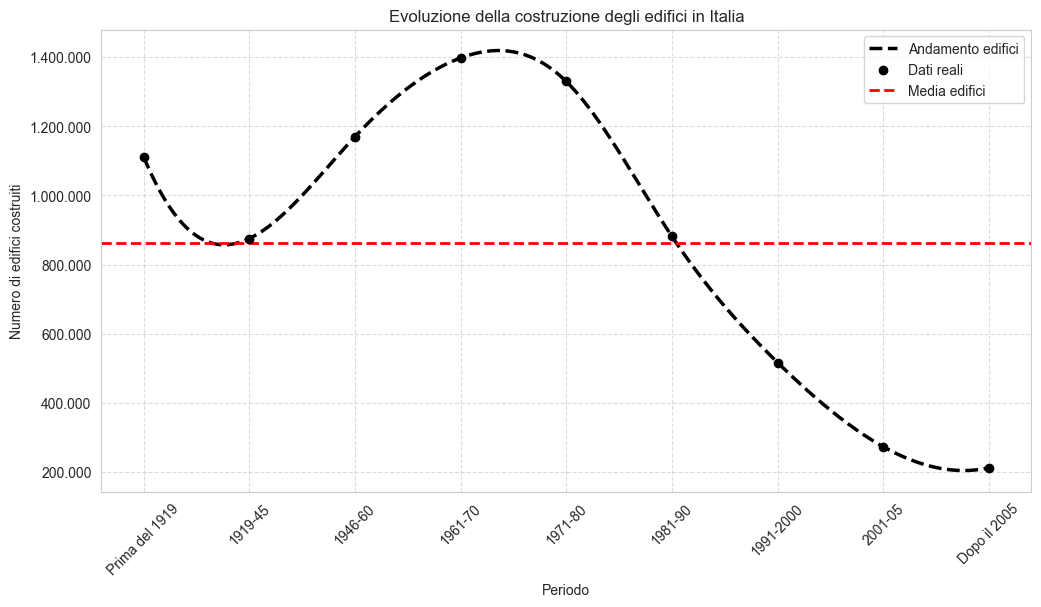

In [16]:
cronologia_edifici(mostra_media=True)

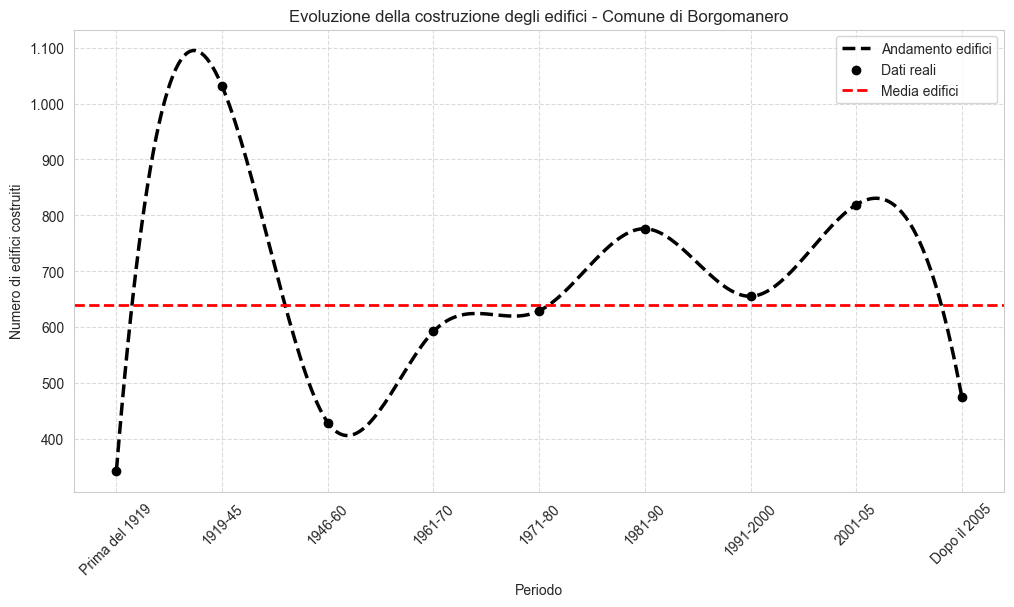

In [17]:
cronologia_edifici('Comune', 'Borgomanero', mostra_media=True)

In [8]:
def crescita_edifici():
    cronologia_edifici = dfs['cronologia_edifici']
    cronologia_edifici = cronologia_edifici[[cronologia_edifici.columns[-1]] + list(cronologia_edifici.columns[:-1])]

    # Creazione del DataFrame
    df = pd.DataFrame(cronologia_edifici)

    # Calcolo del numero totale di edifici costruiti prima e dopo il 2001
    df["Prima del 2001"] = df.iloc[:, 1:8].sum(axis=1)  # Somma colonne da "Prima del 1919" a "1991-2000"
    df["Dal 2001 in poi"] = df.iloc[:, 8:].sum(axis=1)  # Somma colonne "2001-05" e "Dopo il 2005"

    # Calcolo dell'aumento assoluto e percentuale
    df["Aumento Assoluto"] = df["Dal 2001 in poi"] - df["Prima del 2001"]
    df["Aumento Percentuale"] = round((df["Aumento Assoluto"] / df["Prima del 2001"]) * 100, 2)

    # Selezione dei 30 comuni con maggiore aumento
    df_top = df.sort_values(by="Aumento Assoluto", ascending=False)

    # Visualizzazione della tabella
    df_top = df_top[["Comune", "Prima del 2001", "Dal 2001 in poi", "Aumento Assoluto", "Aumento Percentuale"]]
    df_top = df_top[df_top['Aumento Percentuale'] > 1]

    df_top = pd.merge(df_top, dfs['comunali'][['Provincia', 'Comune', 'Regione', 'Zona']], on='Comune')
    
    return df_top.sort_values(by='Aumento Percentuale', ascending=False)

crescita_edifici().head(22)

,Comune,Prima del 2001,Dal 2001 in poi,Aumento Assoluto,Aumento Percentuale,Provincia,Regione,Zona
323,Castiadas,120,377,257,214.17,Sud Sardegna,Sardegna,Ovest
1326,Villa Sant'Angelo,81,180,99,122.22,L'Aquila,Abruzzo,Sud
2672,Battuda,40,86,46,115.00,Pavia,Lombardia,Nord
1633,Roncaro,80,161,81,101.25,Pavia,Lombardia,Nord
3607,Rognano,29,57,28,96.55,Pavia,Lombardia,Nord
4032,Torre d'Isola,23,44,21,91.30,Pavia,Lombardia,Nord
5090,Vernate,11,21,10,90.91,Milano,Lombardia,Nord
351,San Demetrio ne' Vestini,292,537,245,83.90,L'Aquila,Abruzzo,Sud
674,Curtatone,196,358,162,82.65,Mantova,Lombardia,Nord
2067,Valtopina,89,154,65,73.03,Perugia,Umbria,Centro


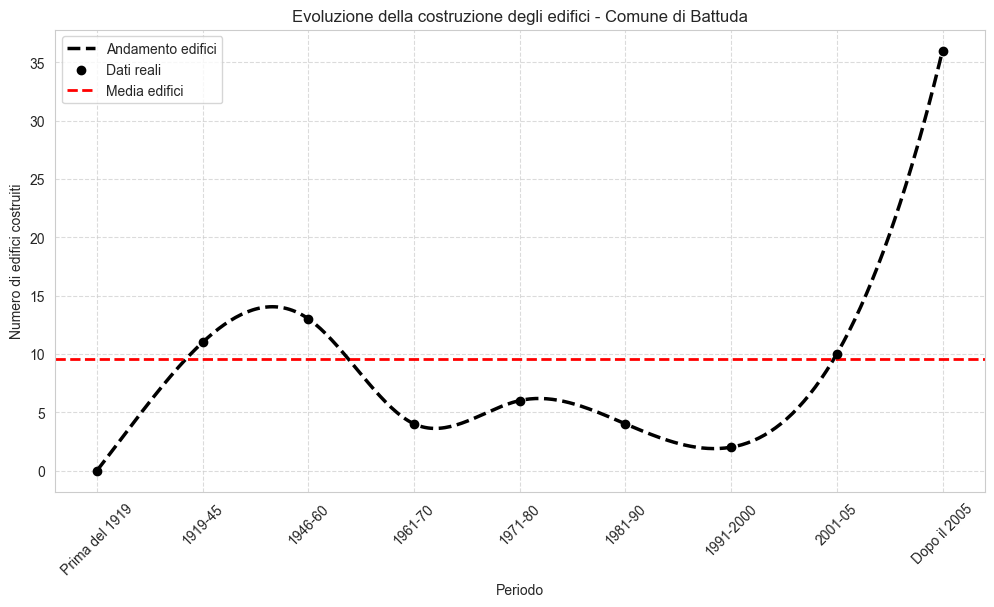

In [18]:
cronologia_edifici('Comune', "Battuda", mostra_media=True)

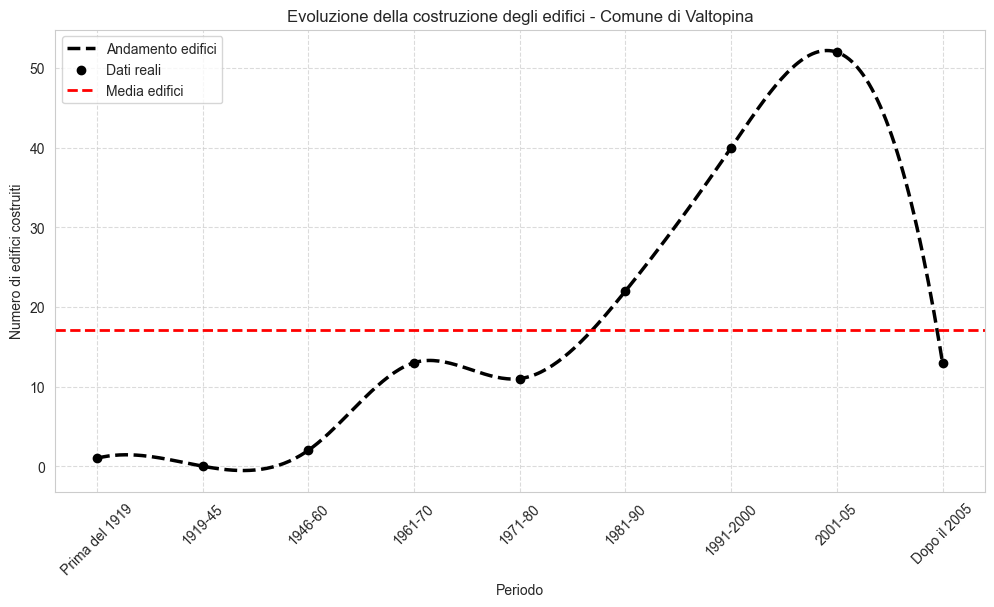

In [35]:
cronologia_edifici('Comune', "Valtopina", mostra_media=True)

In [37]:
df_crescita_per_i_comuni_principali = pd.merge(crescita_edifici(), dfs['comunali'][['Comune', 'Abitanti']], on='Comune')
df_crescita_per_i_comuni_principali = df_crescita_per_i_comuni_principali[df_crescita_per_i_comuni_principali['Abitanti'] >= 6000]
df_crescita_per_i_comuni_principali.head(10)

,Comune,Prima del 2001,Dal 2001 in poi,Aumento Assoluto,Aumento Percentuale,Provincia,Regione,Zona,Abitanti
8,Curtatone,196,358,162,83,Mantova,Lombardia,Nord,14804
29,San Giuliano Terme,261,385,124,48,Pisa,Toscana,Centro,31399
34,Labico,611,885,274,45,Roma,Lazio,Centro,6379
39,Ozzano dell'Emilia,406,580,174,43,Bologna,Emilia-Romagna,Nord,13596
42,Riano,903,1282,379,42,Roma,Lazio,Centro,10466
47,Carmagnola,2193,3092,899,41,Torino,Piemonte,Nord,29079
64,Terno d'Isola,586,804,218,37,Bergamo,Lombardia,Nord,8014
72,Granarolo dell'Emilia,368,502,134,36,Bologna,Emilia-Romagna,Nord,11910
95,Lavagno,311,416,105,34,Verona,Veneto,Nord,8435
98,Trecastelli,344,457,113,33,Ancona,Marche,Centro,7625


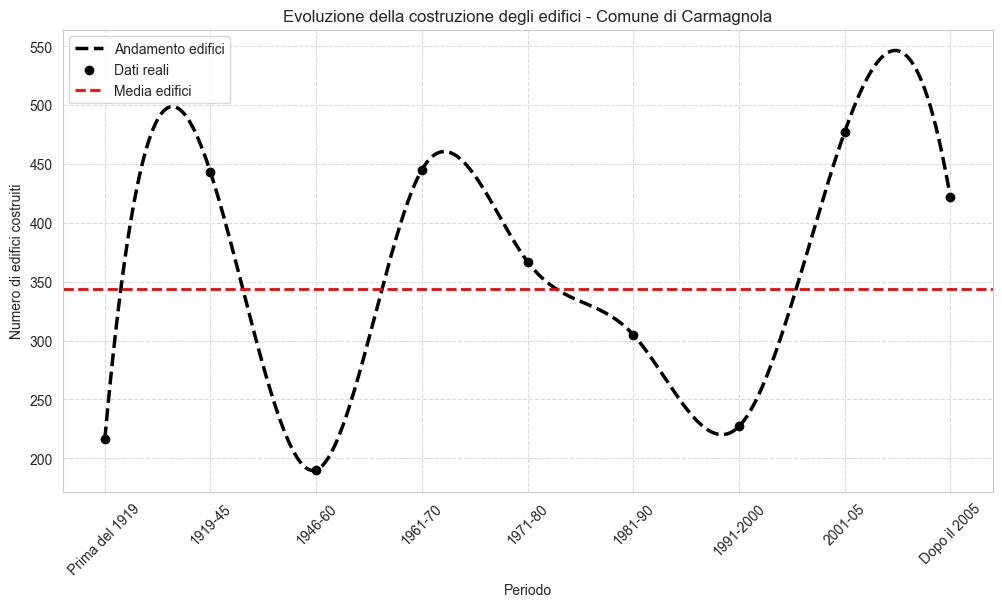

,Municipio,Provincia,Distanza dal capoluogo (Km),Comune,Regione,Zona,sigla_provincia,Abitanti,Età (Media),Parrocchie,Parrrocchiani,Totale di stranieri,Scuole,Diplomati,Laureati,Licenza Elementare Totale,Liscenziati Midia Totale,Alfabeti,Analfabeti,Industria Addetti (%),Servizi Addetti (%),Amministrazione Addetti (%),Altro Addetti (%),Media annuale (Redditi €),Media Mensile (Redditi €),Imposta netta annuale (€),Imposta netta mensile (€)
481,Piazza Manzoni 12,Torino,31,Carmagnola,Piemonte,Nord,TO,29079,42,7,417,2362,31,6313,1630,4482,7435,1555,146,0,0,0,0,22784,1899,4558,380


In [40]:
cronologia_edifici('Comune', "Carmagnola", mostra_media=True)
dfs['comunali'][dfs['comunali']['Comune'] == "Carmagnola"]

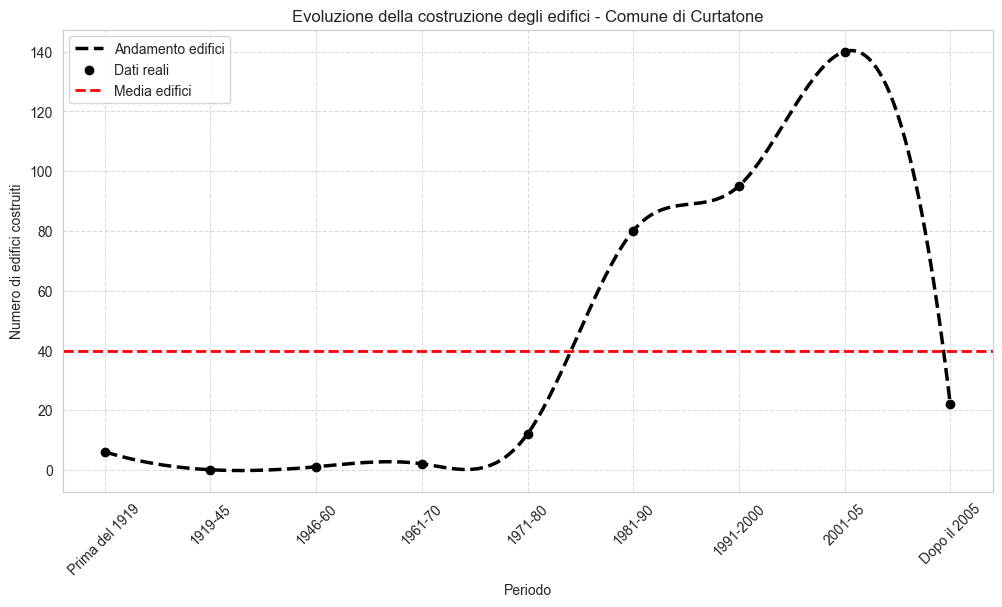

,Municipio,Provincia,Distanza dal capoluogo (Km),Comune,Regione,Zona,sigla_provincia,Abitanti,Età (Media),Parrocchie,Parrrocchiani,Totale di stranieri,Scuole,Diplomati,Laureati,Licenza Elementare Totale,Liscenziati Midia Totale,Alfabeti,Analfabeti,Industria Addetti (%),Servizi Addetti (%),Amministrazione Addetti (%),Altro Addetti (%),Media annuale (Redditi €),Media Mensile (Redditi €),Imposta netta annuale (€),Imposta netta mensile (€)
4283,Via Roma 38,Mantova,7,Curtatone,Lombardia,Nord,MN,14804,41,4,0,88,15,599,223,303,496,104,4,0,81,40,67,22580,1882,5418,451


In [38]:
cronologia_edifici('Comune', 'Curtatone', mostra_media=True)
dfs['comunali'][dfs['comunali']['Comune'] == "Curtatone"]

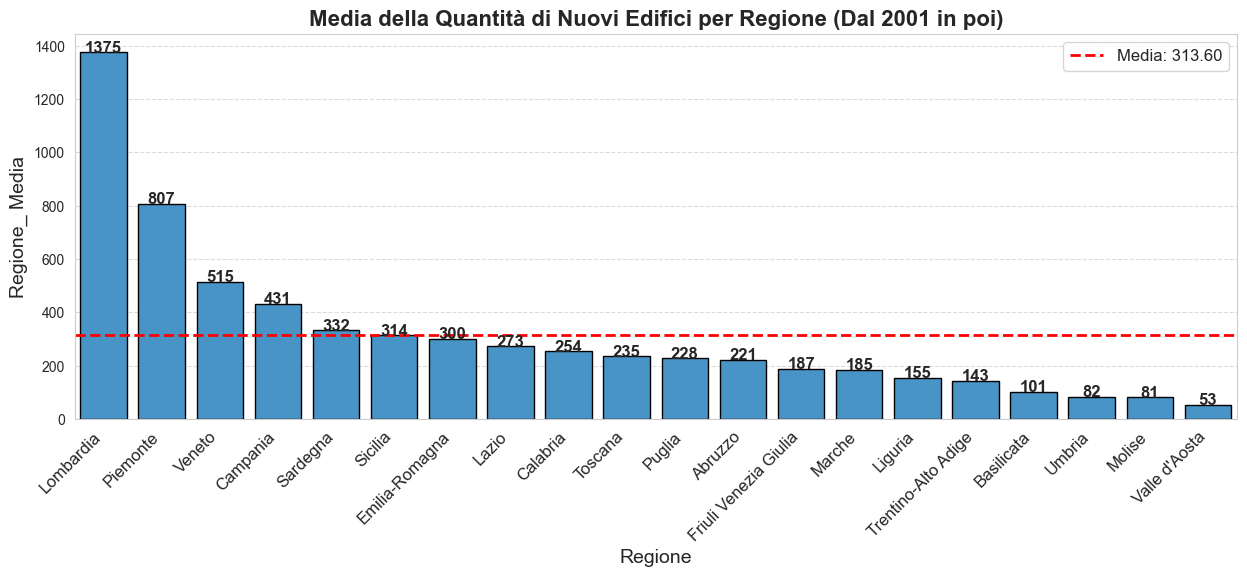

In [12]:
grafico_barre(pd.DataFrame(crescita_edifici().groupby('Regione')['Regione'].count().sort_values(ascending=False)).rename(columns={'Regione': 'Regione_'}), 
              'Regione', 'Regione_', 'Media della Quantità di Nuovi Edifici per Regione (Dal 2001 in poi)', figsize=(15, 5), mostra_media=True)

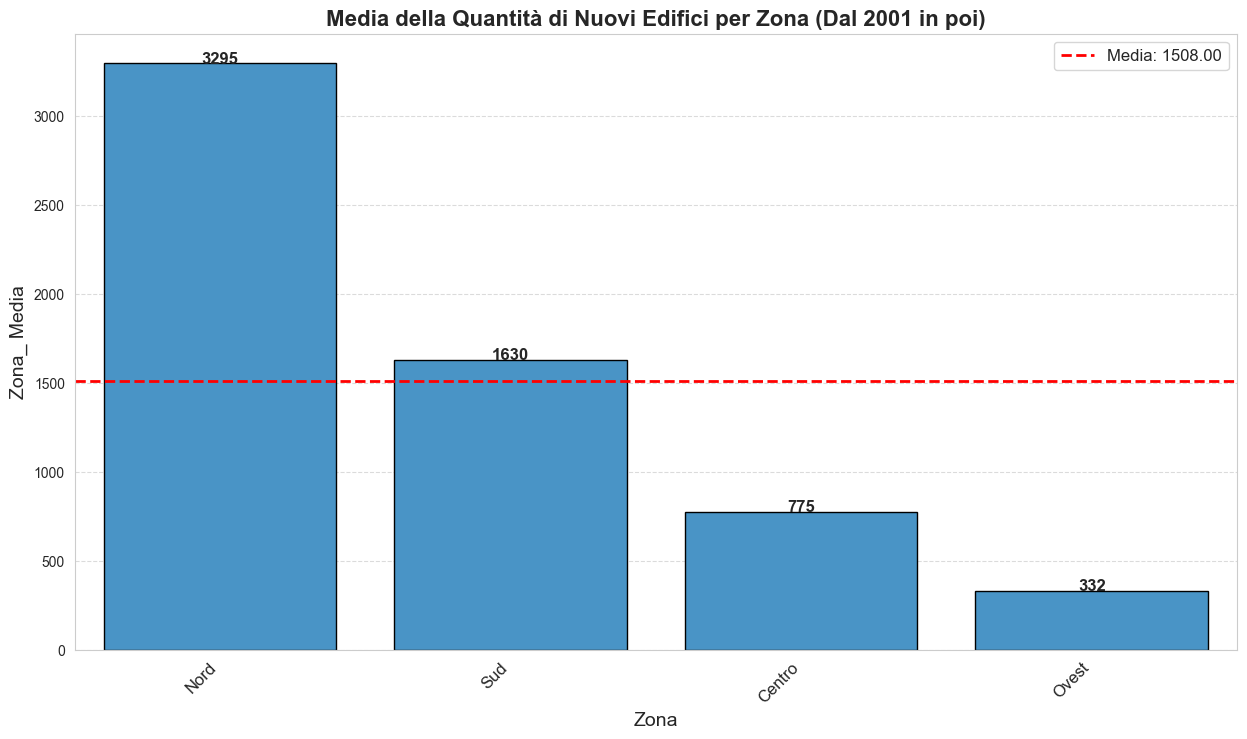

In [13]:
grafico_barre(pd.DataFrame(crescita_edifici()[crescita_edifici()['Zona'] != "Sconosciuto"].groupby('Zona')['Zona'].count().sort_values(ascending=False)).rename(columns={'Zona': 'Zona_'}), 
              'Zona', 'Zona_', 'Media della Quantità di Nuovi Edifici per Zona (Dal 2001 in poi)', figsize=(15, 8), mostra_media=True)